In [1]:
import numpy as np
import pandas as pd
import pickle 
import random
import matplotlib.pyplot as plt
import joblib

In [19]:
scaler_x = joblib.load('scaler_x.pkl')
scaler_y = joblib.load('scaler_y.pkl')

df_scaled = pd.read_csv("Test.csv")
del df_scaled['Unnamed: 0']
lb = 5
players = df_scaled['Starters'].unique()

def format(df_scaled, lb):
  x_list = []
  y_list = []
  for player in (players):
      ar_mid = df_scaled[df_scaled['Starters'] == player].values
      if ar_mid.shape[0] < lb+1:
          pass
      else:
          for i in range(0, ar_mid.shape[0] - lb):
              x = ar_mid[i: i + lb, 1:-1]
              y = ar_mid[i + lb, -1]
              x_list.append(x)
              y_list.append(y)
              
  x_data = np.stack(x_list)
  y_data = np.stack(y_list)
  return x_data, y_data

x_data, y_data = format(df_scaled, lb)
x_data.shape, y_data.shape

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.0 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


((103513, 5, 32), (103513,))

In [20]:
import keras
from keras.layers import Dense, Flatten, Reshape, Input
from keras.layers import  Dense, Lambda, dot, Activation, concatenate, LSTM, BatchNormalization, TimeDistributed
from keras.models import Sequential, Model
from keras.callbacks import History 
from keras.layers import Activation, Dropout, Flatten, Dense

In [21]:
index_list = []
for i in range(0, x_data.shape[0]):
  index_list.append(i)

random.shuffle(index_list)

x_final = np.zeros_like(x_data)
y_final = np.zeros_like(y_data)
for i in range(0,x_data.shape[0]):
  x_final[i,:,:] = x_data[index_list[0]]
  y_final[i] = y_data[index_list[0]]
  index_list.pop(0)

split = int(x_final.shape[0] * .8)

x_train = x_final[0:split, :,:]
y_train = y_final[0:split,]
x_test = x_final[split:x_final.shape[0],:,:]
y_test = y_final[split:y_final.shape[0]]

x_train = np.asarray(x_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
x_test = np.asarray(x_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

x_train.shape, y_train.shape, x_test.shape, y_train.shape

((82810, 5, 32), (82810,), (20703, 5, 32), (82810,))

In [22]:
history = History()
model = Sequential()

inp = Input(x_data[0].shape)
x = (LSTM(32, return_sequences=True))(inp)
x = (Dropout(.05))(x)
x = (BatchNormalization())(x)
x = (LSTM(16))(x)
x = (Dropout(.05))(x)
out = (Dense(1, activation = 'relu'))(x)

model = Model(inputs = inp, outputs = out)
model.compile(
  optimizer='adam',
  loss='mean_squared_error'
)

model.summary()

model.fit(x_train, y_train,
          batch_size=100,
          epochs=5,
          verbose=1,
          shuffle = False,
          validation_data=(x_test, y_test),
          callbacks=[history])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 32)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 32)             8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 32)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 32)             128       
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17  

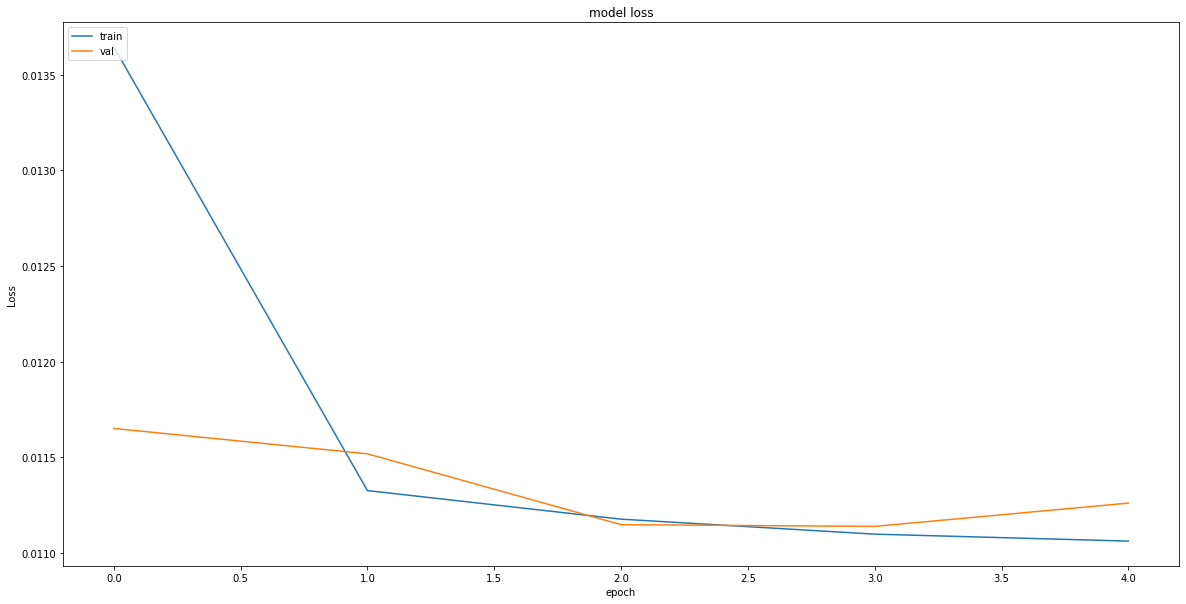

In [23]:
fig = plt.figure(figsize=(20,10))
ax = plt.subplot()

x = np.arange(0,len(history.history['loss']))

ax.plot(x,history.history['loss'])
ax.plot(x,history.history['val_loss'])


plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
from keras.models import model_from_json

model_json = model.to_json()

with open("MODEL.json", "w") as json_file:
      json_file.write(model_json)

model.save_weights("UP.h5")

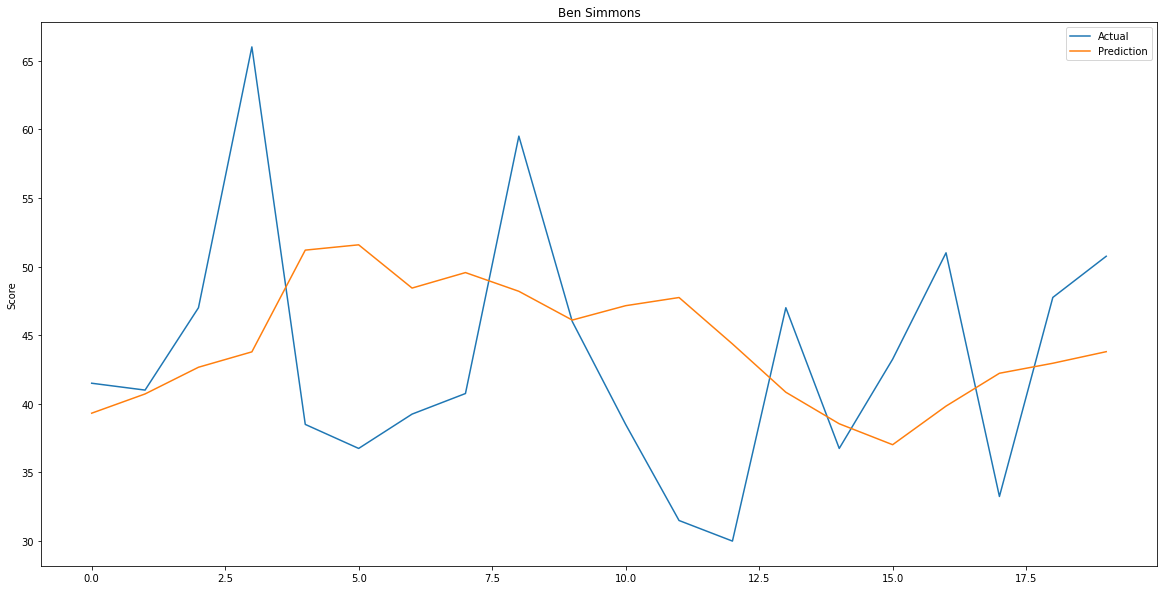

In [34]:
df = pd.read_csv("Test.csv")
del df['Unnamed: 0']

player = 'Ben Simmons'
df = df[df['Starters'] == player]
x_array, y_array = format(df, 5)

co = 20
actual = scaler_y.inverse_transform((y_array[-co:].reshape(-1,1)))
x_array = np.asarray(x_array).astype('float32')
preds = scaler_y.inverse_transform(model.predict(x_array[-co:]))

fig = plt.figure(figsize=(20,10))
ax = plt.subplot()

ax.plot(actual, label = 'Actual')
ax.plot(preds, label = 'Prediction')
plt.ylabel("Score")
plt.title(player)
ax.legend()